In [1]:
import os
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
matplotlib.style.use('seaborn')
sns.set(style='whitegrid', color_codes=True)

save_path = './figures'
if not os.path.exists(save_path):
    os.makedirs(save_path) 

save_type = 'png'

In [3]:
def remove_pts(x,y, kill_num=800):
    randidx = []
    hf = kill_num // 2

    idx = np.where(y==0)[0]
    sorted_idx = x[:,0][idx].argsort()
    randidx.append( idx[sorted_idx[-hf:]] )

    idx = np.where(y==2)[0]
    sorted_idx = x[:,1][idx].argsort()
    randidx.append( idx[sorted_idx[:(kill_num-hf)]] )

    randidx = np.concatenate(randidx)

    x = np.delete(x, randidx, axis=0)
    y = np.delete(y, randidx, axis=0)
    
    return x, y

In [4]:
def draw_scatter(x, y, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(8,7)).add_subplot(111)

    axes = plt.gca()
    axes.set_xlim([-6,6])
    axes.set_ylim([-4.5,6.5])
    fig.tick_params(labelsize=20)
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.08, top=0.92)

    kk = y.max() + 1
    color = [
        sns.xkcd_rgb['soft pink'],
        sns.xkcd_rgb['windows blue'],
        sns.xkcd_rgb['macaroni and cheese'],
        sns.xkcd_rgb['soft green'],
    ]

    for k in range(kk):
        idx = np.where(y==k)
        pts = x[idx]
        plt.scatter(pts[:,0], y=pts[:,1], alpha=0.3, edgecolors='none', color=color[k])

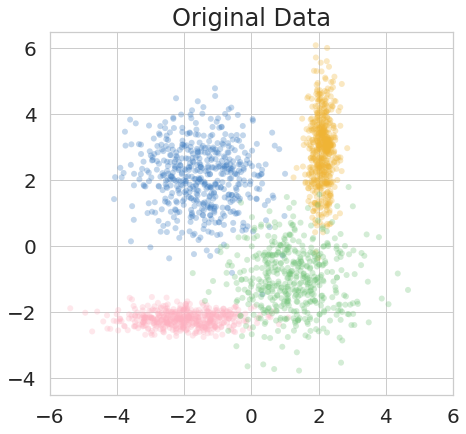

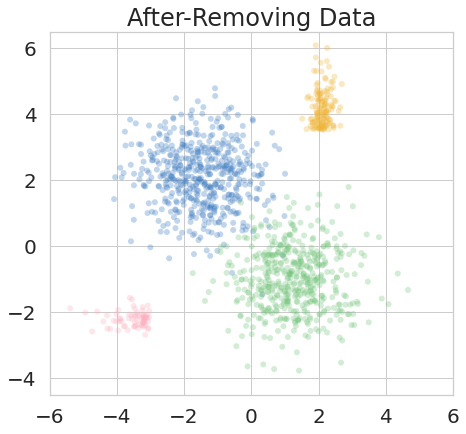

In [5]:
with open('../data/GMMs/gmm-2d-syn-set.pkl', 'rb') as f:
    raw_dataset = pickle.load(f)

fig = plt.figure(figsize=(7,6)).add_subplot(111)

plt.title('Original Data', fontsize=24)

draw_scatter(raw_dataset['x'], raw_dataset['y'], fig)
plt.savefig(save_path+'/gmm-raw-data.{}'.format(save_type))


remain_x, remain_y = remove_pts(raw_dataset['x'], raw_dataset['y'], kill_num=800)

fig = plt.figure(figsize=(7,6)).add_subplot(111)
plt.title('After-Removing Data', fontsize=24)

draw_scatter(remain_x, remain_y, fig)
plt.savefig(save_path+'/gmm-rm-data.{}'.format(save_type))

In [6]:
def plot_clusters(kk, mu, fig=None, color='black', marker='o', label=None):
    if fig is None:
        fig = plt.figure(figsize=(8,7)).add_subplot(111)
    fig.scatter(mu[0,:], mu[1,:], color=color, marker=marker, zorder=3, linewidths=3, label=label)

In [7]:
def plot_samples(kk, pts, fig=None, cls_ord=None):
    if fig is None:
        fig = plt.figure(figsize=(8,7)).add_subplot(111)
    if cls_ord is None: cls_ord = range(kk)
    for k in cls_ord:
        fig.plot(pts[:,0,k], pts[:,1,k], alpha=0.8)

In [8]:
def mcmc_visual(name, path, cls_ord=None):
    fig = plt.figure(figsize=(7,6)).add_subplot(111)
    plt.title('{} - Before Forgetting'.format(name), fontsize=24)
    
    draw_scatter(raw_dataset['x'], raw_dataset['y'], fig)
    
    with open('{}/full-train-ckpt-cluster.pkl'.format(path), 'rb') as f:
        npd_cls = pickle.load(f)
    with open('{}/full-train-ckpt-samp-pts.pkl'.format(path), 'rb') as f:
        npd_pts = pickle.load(f)
    plot_clusters(npd_cls['kk'], npd_cls['mk'], fig, color=sns.xkcd_rgb['black'], marker='o', label='Origin')
    plot_samples(npd_cls['kk'], npd_pts, fig, cls_ord=cls_ord)
    plt.legend(loc='upper left', fontsize=18)
    
    plt.savefig('{}/gmm-{}-full.{}'.format(save_path, name, save_type))
    
    
    
    fig = plt.figure(figsize=(7,6)).add_subplot(111)
    plt.title('{} - After Forgetting'.format(name), fontsize=24)
    plot_clusters(npd_cls['kk'], npd_cls['mk'], fig, color=sns.xkcd_rgb['black'], marker='o', label='Origin')
    with open('{}/forget-ckpt-cluster.pkl'.format(path), 'rb') as f:
        pd_cls = pickle.load(f)
    draw_scatter(remain_x, remain_y, fig)
    plot_clusters(pd_cls['kk'], pd_cls['mk'], fig, color=sns.xkcd_rgb['blue blue'], marker='v', label='Processed')
    
    with open('{}/scratch-ckpt-cluster.pkl'.format(path), 'rb') as f:
        scratch_cls = pickle.load(f)
    plot_clusters(scratch_cls['kk'], scratch_cls['mk'], fig, color=sns.xkcd_rgb['red'], marker='*', label='Target')
    plt.legend(loc='upper left', fontsize=18)
    
    plt.savefig('{}/gmm-{}-forget.{}'.format(save_path, name, save_type))

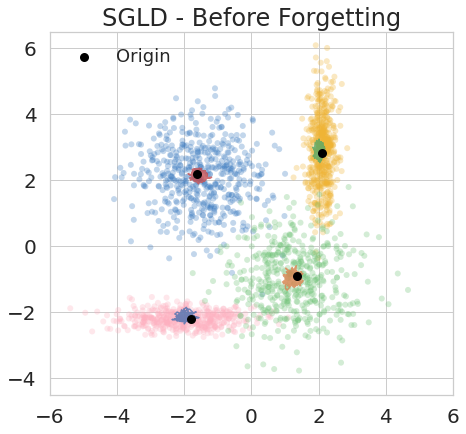

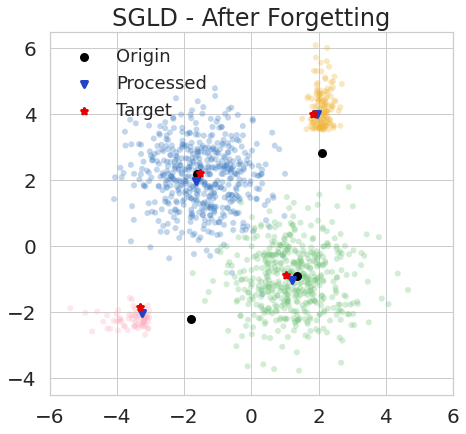

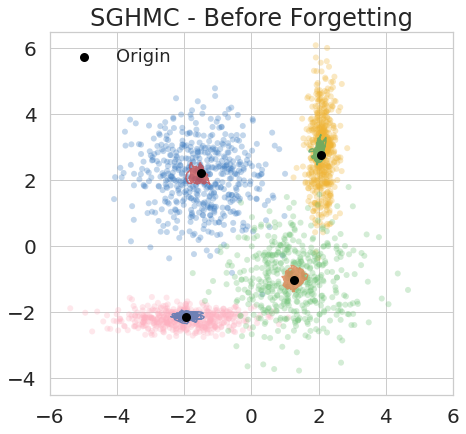

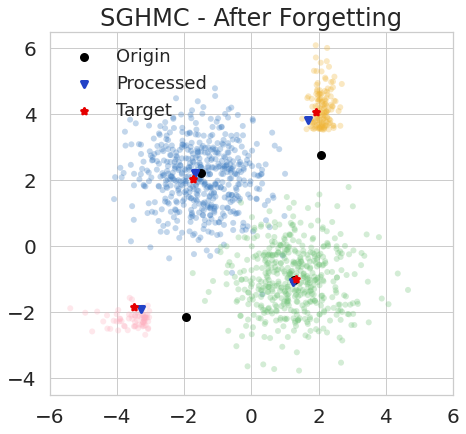

In [9]:
mcmc_visual('SGLD', '../exp_data/gmm/sgld', cls_ord=[2,1,3,0])
mcmc_visual('SGHMC', '../exp_data/gmm/sghmc', cls_ord=[1,2,3,0])